<a href="https://colab.research.google.com/github/ESA-PhiLab/Major-TOM/blob/main/06-Read-AlphaEarth-Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Major TOM x AlphaEarth - Full Catalogue
> Reading AlphaEarth Embeddings as Major TOM products from the s3 mirror of the data Source Cooperative

We have recently witnessed a fantastic community collaboration in a group effort to #FreeTheEmbeddings. As a result, 465TB of Google's [AlphaEarth](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_SATELLITE_EMBEDDING_V1_ANNUAL) embeddings are now available on [Source Cooperative](https://source.coop/) as a result of brilliant work of Jeff Albrecht (LGND AI), Jennifer Marcus (Taylor Geospatial Engine), and Jed Sundwall (Radiant Earth).

This notebook is provided as a community contribution from [Asterisk Labs](https://asterisk.coop/), because we love open data, and we love it even more when it's easy to use and combine with other sources. So here's an example how to read a Major TOM compatible product directly from the archive of 465 TBs of AlphaEarth embeddings - enjoy!

### Links
**💽 Dataset on source.coop built by Jeff Albrecht**: [https://source.coop/tge-labs/aef](https://source.coop/tge-labs/aef)

**🌐 Blog post by Jennifer Marcus**: [https://tgengine.org/building-frictionless-geospatial-ai-making-alphaearth-foundations-embeddings-accessible/](https://tgengine.org/building-frictionless-geospatial-ai-making-alphaearth-foundations-embeddings-accessible/)

**📚 STAC Conversion by Isaac Corley**: [https://huggingface.co/datasets/isaaccorley/AEF](https://huggingface.co/datasets/isaaccorley/AEF) (🔎 [Online Map of STAC](https://developmentseed.org/stac-map/?href=https://huggingface.co/datasets/isaaccorley/AEF/resolve/main/aef-index-stac-geoparquet.parquet))

**🗺 Major TOM AlphaEarth Subset**: [https://huggingface.co/datasets/Major-TOM/Core-AlphaEarth-Embeddings](https://huggingface.co/datasets/Major-TOM/Core-AlphaEarth-Embeddings)

### Limitations
This is a quick example notebook. Currently, no mosaicing is applied, so if you're unlucky enough to request a cell that is split between multiple COG files, you will end up with an incomplete sample.

### Terms of Use

The data is licensed under CC-BY 4.0 and requires the following attribution text: "The AlphaEarth Foundations Satellite Embedding dataset is produced by Google and Google DeepMind."

In [1]:
!pip install git+https://github.com/ESA-PhiLab/Major-TOM.git s3fs

  Cloning https://github.com/ESA-PhiLab/Major-TOM.git to /tmp/pip-req-build-tu0x13gz
  Running command git clone --filter=blob:none --quiet https://github.com/ESA-PhiLab/Major-TOM.git /tmp/pip-req-build-tu0x13gz
  Resolved https://github.com/ESA-PhiLab/Major-TOM.git to commit 4fba0d0889fc02d179cb38d8f0b44818c4a89234
  Preparing metadata (setup.py) ... done


## 🧰 Imports & Tools

In [2]:
# ==============================================================================
# 1. Standard Library Imports
# ==============================================================================
import json
import os
from io import BytesIO

# ==============================================================================
# 2. Third-Party Library Imports
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from affine import Affine # Recommended for working with rasterio transforms
from shapely.geometry import Polygon, Point
import pyproj
from sklearn.decomposition import PCA
from PIL import Image

# Geospatial/Cloud Tools
import rasterio as rio
from rasterio.windows import from_bounds
import s3fs
from fsspec.parquet import open_parquet_file
import pyarrow.parquet as pq

# Major TOM
import majortom as MT

# ==============================================================================
# 3. Utility Functions
# ==============================================================================

def row2thumbnail(row):
    '''
        Read the thumbnail column from a Major TOM metadata parquet row
    '''

    with open_parquet_file(row.parquet_url,columns = ["thumbnail"]) as f:
        with pq.ParquetFile(f) as pf:
            first_row_group = pf.read_row_group(row.parquet_row, columns=['thumbnail'])

    stream = BytesIO(first_row_group['thumbnail'][0].as_py())
    return Image.open(stream)

def rgb_pca(arr: np.ndarray) -> Image.Image:
    """
    Applies PCA to a 3D array to reduce its dimensions to 3,
    then converts it into a PIL Image.

    Args:
        arr (np.ndarray): Input array of shape (H, W, C).

    Returns:
        Image.Image: A PIL Image object ready to be saved.
    """
    h,w,c=arr.shape

    # Ensure the input array has the correct shape
    if len(arr.shape) != 3:
        raise ValueError("Input array must be of shape (Height, Width, Channels)")

    # Reshape the array for PCA
    reshaped_arr = arr.reshape(-1, c)

    # Initialize and fit PCA to reduce dimensions to 3
    pca = PCA(n_components=3)
    pca.fit(reshaped_arr)

    # Transform the data using the fitted PCA
    transformed_arr = pca.transform(reshaped_arr)

    # Normalize the data to the 0-255 range for image conversion
    # Min-Max scaling for each principal component
    normalized_arr = np.zeros_like(transformed_arr)
    for i in range(transformed_arr.shape[1]):
        min_val = transformed_arr[:, i].min()
        max_val = transformed_arr[:, i].max()
        normalized_arr[:, i] = 255 * (transformed_arr[:, i] - min_val) / (max_val - min_val)

    # Reshape the array back to its original dimensions (h, w, 3)
    # and convert to an 8-bit unsigned integer type
    rgb_image_data = (normalized_arr).reshape(h, w, 3).astype(np.uint8)

    # Create a PIL Image from the processed NumPy array
    #return arr
    pil_image = Image.fromarray(rgb_image_data*(arr.sum(-1)!=c*65535)[:,:,None])

    return pil_image

def get_product_window(lat, lon, utm_zone=4326, mt_grid_dist = 10, box_size = 10680):
    """
        Takes a reference coordinate for top-left corner (lat, lon) of a Major TOM cell
        and returns a product footprint for a product in the specified utm_zone (needs to be extracted from a given product)


        mt_grid_dist (km) : distance of a given Major TOM grid (10 km is the default)
        box_size (m) : length
    """
    # offset distributed evenly on both sides
    box_offset = (box_size-mt_grid_dist*1000)/2 # metres

    if isinstance(utm_zone, int):
        utm_crs = f'EPSG:{utm_zone}'
    else:
        utm_crs = utm_zone

    # Define transform
    transformer = pyproj.Transformer.from_crs('EPSG:4326', utm_crs, always_xy=True)

    # Get corners in UTM coordinates
    left,bottom = transformer.transform(lon, lat)
    left,bottom = left-box_offset, bottom-box_offset
    right,top = left+box_size,bottom+box_size

    utm_footprint = Polygon([
        (left,bottom),
        (right,bottom),
        (right,top),
        (left,top)
    ])

    return utm_footprint, utm_crs

## ⚙️ Initialise

In [3]:
# Init s3fs
print('Initialising s3...')
fs = s3fs.S3FileSystem(anon=True)
print('[DONE]\nReading AEF index from remote location...')
df = gpd.read_parquet('s3://us-west-2.opendata.source.coop/tge-labs/aef/v1/annual/aef_index.parquet')
print('[DONE]\nSetting up 10km Major TOM grid..')
# Set up our usual Major TOM 10 km grid
mt_grid = MT.Grid(10)
print('[DONE]')

# Optional (only if you want to read other datasets)
print('Reading Major TOM metadata for external datasets...')
l1c_df = pd.read_parquet('https://huggingface.co/datasets/Major-TOM/Core-S2L1C/resolve/main/metadata.parquet')
l2a_df = pd.read_parquet('https://huggingface.co/datasets/Major-TOM/Core-S2L2A/resolve/main/metadata.parquet')
rtc_df = pd.read_parquet('https://huggingface.co/datasets/Major-TOM/Core-S1RTC/resolve/main/metadata.parquet')
dem_df = pd.read_parquet('https://huggingface.co/datasets/Major-TOM/Core-DEM/resolve/main/metadata.parquet')
print('[DONE]')

Initialising s3...
[DONE]
Reading AEF index from remote location...
[DONE]
Setting up 10km Major TOM grid..
[DONE]
Reading Major TOM metadata for external datasets...
[DONE]


## 🕵 Querying
You can query by specifying Major TOM `MT_CELL` or you can directly replace `lats` and `lons` with explicit coordinates.

In [4]:
MT_CELL = '454U_119R' #'626U_29L' #'283U_505R'
MT_ROW, MT_COL = MT_CELL.split('_')
YEAR = 2019

# 1. define major tom grid cell
lats, lons = mt_grid.rowcol2latlon([MT_ROW],[MT_COL])

# 2. find the right COG
aef_row = df[df.contains(Point(lons,lats)) & (df.year == YEAR)].iloc[0]

# 3. map lat-lon to utm footprint
window, proj = get_product_window(lats[0], lons[0], utm_zone=aef_row.crs)

In [5]:
# Set the environment variable for GDAL to enable S3 access over HTTPS
# This is crucial for reading COGs directly from S3.
with rio.Env(
    aws_unsigned=True,
    aws_no_sign_request=True,
    GDAL_DISABLE_READ_LOCK='YES',
    CPL_VSI_CURL_USE_HEAD='NO'
):
    with rio.open(aef_row.path) as src:
        minx, miny, maxx, maxy = window.bounds
        src_window = from_bounds(minx, maxy, maxx, miny, src.transform) # CAREFUL - COGs here are non-standard (positive y-dir, so require reordering)
        arr = src.read(window=src_window).transpose(1,2,0)[::-1,...]

In [6]:
# If you want to extract original dequantised values, here's how to do it (as instructed in the dataset documentation):
deq_arr = ((arr / 127.5) ** 2) * np.sign(arr)

## Voilà!

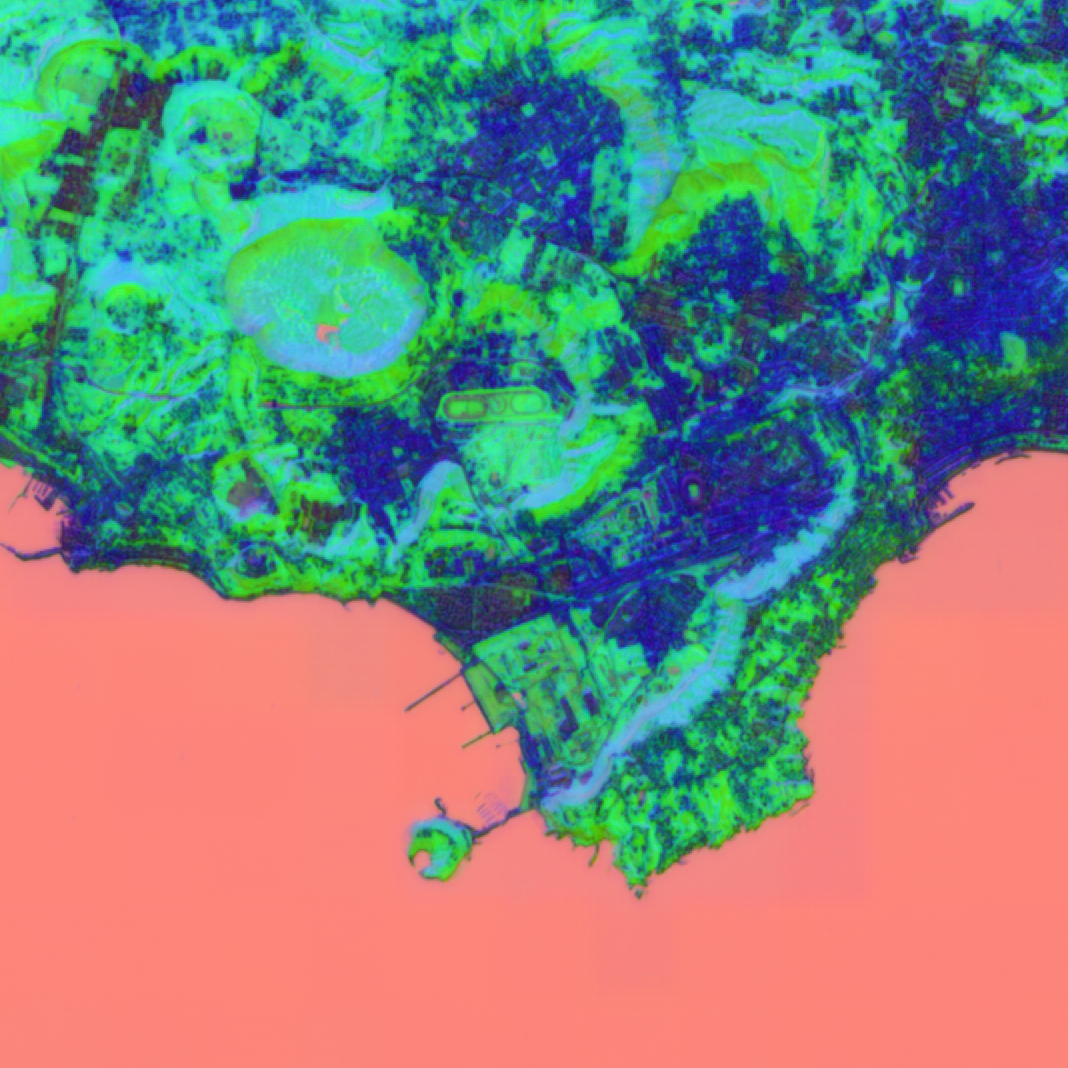

In [7]:
pca_img = rgb_pca(arr)

pca_img

## Combine with other Major TOM Datasets

In [8]:
extra_modalities = {}
extra_dfs = [l1c_df, l2a_df, rtc_df, dem_df]

for extra_df in extra_dfs:
    extra_row = extra_df[extra_df.grid_cell == MT_CELL]

    if len(extra_row):
        extra_row = extra_row.iloc[0]
        tag = extra_row.parquet_url.split('Major-TOM/')[1].split('/')[0]
        print(f"Matched modality found: {tag}")
        extra_modalities[tag] = row2thumbnail(extra_row)
        print('[DONE]')

Matched modality found: Core-S2L1C


/usr/local/lib/python3.12/dist-packages/fsspec/parquet.py:222: UserWarning: Not enough data was used to sample the parquet footer. Try setting footer_sample_size >= 1108331.
  warnings.warn(


[DONE]
Matched modality found: Core-S2L2A


/usr/local/lib/python3.12/dist-packages/fsspec/parquet.py:222: UserWarning: Not enough data was used to sample the parquet footer. Try setting footer_sample_size >= 1031336.
  warnings.warn(


[DONE]
Matched modality found: Core-S1RTC
[DONE]
Matched modality found: Core-DEM
[DONE]


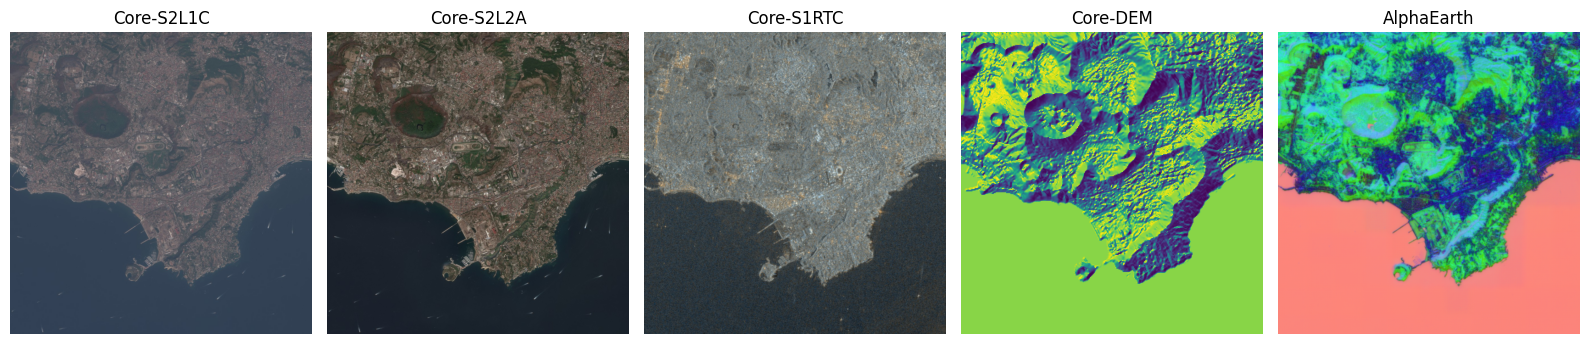

In [9]:
plt.figure(figsize=(16,5))
N=len(extra_modalities)+1

for idx, key in enumerate(extra_modalities):
    plt.subplot(1,N,1+idx)
    plt.title(key)
    plt.imshow(extra_modalities[key])
    plt.axis('off')


plt.subplot(1,N,2+idx)
plt.title('AlphaEarth')
plt.imshow(pca_img)
plt.axis('off')

plt.tight_layout()